In [1]:
#hivemind.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#3 March 2018
#
#This illustrates how to play the hivemind game.

In [2]:
#generate small sample of bucket_yields
N_fields = 4
lag = 1
N_turns = 20
SNR = 1.1                       #signal/noise ratio
rn_seed = 14
from hivemind import *
np.random.seed(seed=rn_seed)
actual_field_yields, best_field, lagged_field_yields, weather, weather_onehot, field_yield_mean, \
    field_yield_sigma = make_bucket_yields(N_fields, N_turns, SNR, lag)

Using TensorFlow backend.


In [3]:
#print actual_field_yields & note that best_field=1 for field having highest actual_field_yields
for idx in range(N_turns):
    print 'actual_field_yields = ', actual_field_yields[idx], '        best_field = ', best_field[idx]

actual_field_yields =  [ 0.          0.00155707 -0.00274039  0.00565763]         best_field =  [ 0.  0.  0.  1.]
actual_field_yields =  [ 0.          0.00330989  0.00276882  0.00506664]         best_field =  [ 0.  0.  0.  1.]
actual_field_yields =  [ 0.          0.00260652  0.00579083  0.00853607]         best_field =  [ 0.  0.  0.  1.]
actual_field_yields =  [ 0.         -0.00119987 -0.00021855  0.00880094]         best_field =  [ 0.  0.  0.  1.]
actual_field_yields =  [ 0.          0.00017922  0.00610507  0.0089685 ]         best_field =  [ 0.  0.  0.  1.]
actual_field_yields =  [ 0.          0.00135119  0.00735315  0.00083518]         best_field =  [ 0.  0.  1.  0.]
actual_field_yields =  [ 0.         -0.00106928 -0.00618294 -0.00956718]         best_field =  [ 1.  0.  0.  0.]
actual_field_yields =  [ 0.          0.00015585  0.00845787  0.00356163]         best_field =  [ 0.  0.  1.  0.]
actual_field_yields =  [ 0.         -0.00011855 -0.00323185 -0.00191733]         best_field =  [

In [4]:
#print lagged_field_yields & note that quantity is actual_field_yields lagged by 1 turn
for idx in range(N_turns):
    print 'lagged_field_yields = ', lagged_field_yields[idx], '        best_field = ', best_field[idx]

lagged_field_yields =  [ 0.          0.00153835  0.00356546 -0.00138705]         best_field =  [ 0.  0.  0.  1.]
lagged_field_yields =  [ 0.          0.00155707 -0.00274039  0.00565763]         best_field =  [ 0.  0.  0.  1.]
lagged_field_yields =  [ 0.          0.00330989  0.00276882  0.00506664]         best_field =  [ 0.  0.  0.  1.]
lagged_field_yields =  [ 0.          0.00260652  0.00579083  0.00853607]         best_field =  [ 0.  0.  0.  1.]
lagged_field_yields =  [ 0.         -0.00119987 -0.00021855  0.00880094]         best_field =  [ 0.  0.  0.  1.]
lagged_field_yields =  [ 0.          0.00017922  0.00610507  0.0089685 ]         best_field =  [ 0.  0.  1.  0.]
lagged_field_yields =  [ 0.          0.00135119  0.00735315  0.00083518]         best_field =  [ 1.  0.  0.  0.]
lagged_field_yields =  [ 0.         -0.00106928 -0.00618294 -0.00956718]         best_field =  [ 0.  0.  1.  0.]
lagged_field_yields =  [ 0.          0.00015585  0.00845787  0.00356163]         best_field =  [

In [5]:
#note that actual_field_yields tend to be more negative during hot or stormy weather 
for idx in range(N_turns):
    print 'weather = ', weather[idx], '        actual_field_yields = ', actual_field_yields[idx]

weather =  nominal         actual_field_yields =  [ 0.          0.00155707 -0.00274039  0.00565763]
weather =  nominal         actual_field_yields =  [ 0.          0.00330989  0.00276882  0.00506664]
weather =  nominal         actual_field_yields =  [ 0.          0.00260652  0.00579083  0.00853607]
weather =  nominal         actual_field_yields =  [ 0.         -0.00119987 -0.00021855  0.00880094]
weather =  nominal         actual_field_yields =  [ 0.          0.00017922  0.00610507  0.0089685 ]
weather =  nominal         actual_field_yields =  [ 0.          0.00135119  0.00735315  0.00083518]
weather =  hot         actual_field_yields =  [ 0.         -0.00106928 -0.00618294 -0.00956718]
weather =  nominal         actual_field_yields =  [ 0.          0.00015585  0.00845787  0.00356163]
weather =  nominal         actual_field_yields =  [ 0.         -0.00011855 -0.00323185 -0.00191733]
weather =  hot         actual_field_yields =  [ 0.          0.00088272  0.00350475 -0.00574907]
weather 

In [6]:
#generate larger sample of bucket_yields
N_fields = 60
SNR = 1.1
lag = 1
N_turns = 100
rn_seed = 14
from hivemind import *
np.random.seed(seed=rn_seed)
actual_field_yields, best_field, lagged_field_yields, weather, weather_onehot, field_yield_mean, \
    field_yield_sigma = make_bucket_yields(N_fields, N_turns, SNR, lag)

In [7]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

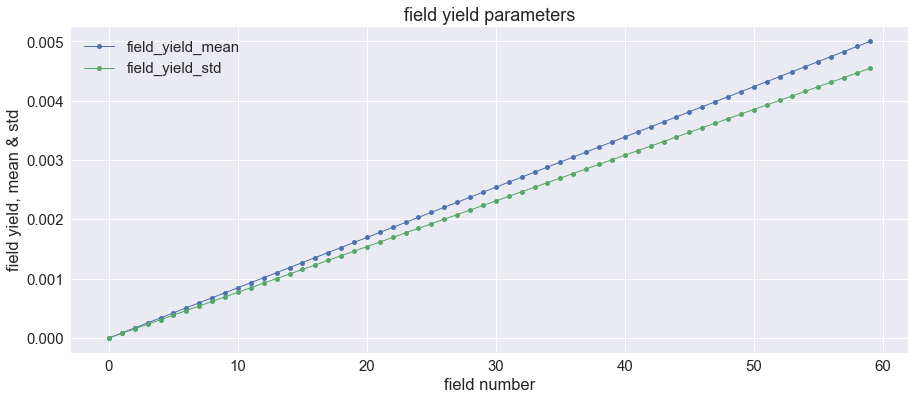

In [8]:
#plot loss vs training epoch...note that bucket_yield_mean has signal/noise=2
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = np.arange(N_fields)
yp = field_yield_mean
ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label='field_yield_mean')
yp = field_yield_sigma
ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label='field_yield_std')
ax.set_title('field yield parameters')
ax.set_ylabel('field yield, mean & std')
ax.set_xlabel('field number')
ax.legend()
plt.savefig('figs/field_parameters.png')

In [9]:
#play single small game and compute net_values vs turn
strategy = 'high'
N_fields = 6
SNR = 1.1
lag = 1
N_turns = 100
actual_field_yields, best_field, lagged_field_yields, weather, weather_onehot, field_yield_mean, \
    field_yield_sigma = make_bucket_yields(N_fields, N_turns, SNR, lag)
net_values = compute_net_value(actual_field_yields, lagged_field_yields, weather, weather_onehot, strategy)
net_values.head(10)

,yield0,yield1,yield2,yield3,yield4,yield5,net_value,prob0,prob1,prob2,prob3,prob4,prob5,compound_value,turn,weather
0,0.0,0.001587,0.000550,0.004998,0.002406,0.013708,1.008057,0.0,0.0,0.0,0.0,0.5,0.5,1.008057,0,nominal
1,0.0,0.001521,0.002384,0.001036,0.004071,0.010167,1.007119,0.0,0.0,0.0,0.0,0.5,0.5,1.015233,1,nominal
2,0.0,0.000126,0.001714,0.000286,0.007187,-0.000132,1.003528,0.0,0.0,0.0,0.0,0.5,0.5,1.018815,2,nominal
3,0.0,-0.000052,0.000949,0.003744,-0.008421,-0.009264,0.991158,0.0,0.0,0.0,0.0,0.5,0.5,1.009806,3,hot
4,0.0,0.001501,0.000473,0.004844,0.008612,0.001362,1.004987,0.0,0.0,0.0,0.0,0.5,0.5,1.014842,4,nominal
5,0.0,0.000154,0.002079,0.006788,-0.003049,0.007499,1.002225,0.0,0.0,0.0,0.0,0.5,0.5,1.017100,5,nominal
6,0.0,0.001572,0.005417,0.001501,-0.000128,0.002783,1.001328,0.0,0.0,0.0,0.0,0.5,0.5,1.018451,6,nominal
7,0.0,0.000262,0.003252,0.000570,0.005420,0.007098,1.006259,0.0,0.0,0.0,0.0,0.5,0.5,1.024825,7,nominal
8,0.0,0.000041,0.003914,0.004891,0.004250,0.004191,1.004221,0.0,0.0,0.0,0.0,0.5,0.5,1.029150,8,nominal
9,0.0,0.001015,0.003061,0.006734,0.000527,0.003822,1.002174,0.0,0.0,0.0,0.0,0.5,0.5,1.031388,9,nominal


In [ ]:
#play 10 games per each strategy and plot their average compound_value vs turn
N_games = 10
N_buckets = 60
lag = 1
N_turns = 100
strategies = ['low', 'middle', 'high', 'top']
fig, ax = plt.subplots(1,1, figsize=(15, 6))
all_net_values = pd.DataFrame()
for strategy in strategies:
    for idx in range(N_games):
        actual_bucket_yields, _, lagged_bucket_yields, _, _, _, _ = make_bucket_yields(N_buckets, N_turns, SNR, lag)
        net_values = compute_net_value(actual_bucket_yields, lagged_bucket_yields, weather, weather_onehot, \
            strategy, model=None)
        net_values['strategy'] = strategy
        all_net_values = all_net_values.append(net_values, ignore_index=True)
g = all_net_values.groupby(['strategy', 'turn'], as_index=False)['compound_value'].agg(['mean', 'std', 'count'])
for strategy in strategies:
    strategy_results = g.loc[strategy]
    xp = strategy_results.index
    yp = strategy_results['mean'].values
    yerr = strategy_results['std'].values
    p = ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label=strategy)
    p = ax.errorbar(xp, yp, yerr=yerr, alpha=0.4, color=p[0].get_color())
p = ax.set_title('mean compound_value generated by various strategies')
p = ax.set_ylabel('compound_value')
p = ax.set_xlabel('turn')
p = ax.legend()

In [ ]:
#generate lots of test-train-validate data: lagged_bucket_yields and best_bucket
N_buckets = 60
lag = 1
SNR = 1.1
N_turns = 100000
actual_bucket_yields, best_bucket, lagged_bucket_yields, weather, weather_onehot, bucket_yield_mean, \
    bucket_yield_sigma = make_bucket_yields(N_buckets, N_turns, SNR, lag)

In [ ]:
#check class imbalance
idx = (weather == 'nominal')
yp = best_bucket.sum(axis=0)
xp = np.arange(len(yp))
fig, ax = plt.subplots(1,1, figsize=(15, 6))
p = ax.plot(xp, yp, linewidth=3)
p = ax.set_title('number of times each bucket is best')
p = ax.set_ylabel("number of best_bucket's")
p = ax.set_xlabel('bucket number')

In [ ]:
#features x = lagged_bucket_yields + weather_onehot
x = np.concatenate((lagged_bucket_yields, weather_onehot), axis=1)
idx = 4
print 'lagged_bucket_yields = ', lagged_bucket_yields[idx]
print 'weather_onehot = ', weather_onehot[idx]
print 'x = ', x[idx]
#target y = best_bucket
y = best_bucket
print 'y = ', y[idx]

In [ ]:
#test-train-validation split is 1:1:1
train_fraction = 0.333
from sklearn.model_selection import train_test_split
x_train, x_test_validate, y_train, y_test_validate = train_test_split(x, y, train_size=train_fraction, 
    test_size=(1-train_fraction), random_state=rn_seed)
train_fraction = 0.5
x_test, x_validate, y_test, y_validate = \
    train_test_split(x_test_validate, y_test_validate, train_size=train_fraction, random_state=rn_seed)
print x.shape, y.shape
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape
print x_validate.shape, y_validate.shape

In [ ]:
#build MLP classification model 
N_inputs = x.shape[1]
N_outputs = y.shape[1]
N_middle_layer = 0*N_outputs
dropout_fraction = 0.0
model = mlp_classifier(N_inputs, N_middle_layer, N_outputs, dropout_fraction)
model.summary()

In [ ]:
#fit model to predict most productive bucket
N_epochs = 25
batch_size = N_turns/100
print 'layers = ', N_inputs, N_middle_layer, N_outputs
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(N_inputs, N_middle_layer, N_outputs, dropout_fraction)
fit_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=N_epochs, verbose=0, 
    validation_data=(x_validate, y_validate))

In [ ]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
p = ax.plot(xp, yp, linewidth=1, label='training sample')
yp = fit_history.history['val_loss']
p = ax.plot(xp, yp, linewidth=1, label='validation sample')
p = ax.set_title('loss function versus training epoch')
p = ax.set_ylabel('loss function')
p = ax.set_xlabel('training epoch')
p = ax.legend()

In [ ]:
#play 10 short games using each strategy and plot their mean compound_value
N_games = 10
N_turns = 100
top_k = 6
strategies = ['low', 'middle', 'high', 'top', 'smart']
fig, ax = plt.subplots(1,1, figsize=(15, 6))
all_net_values = pd.DataFrame()
for strategy in strategies:
    for idx in range(N_games):
        actual_bucket_yields, best_bucket, lagged_bucket_yields, weather, weather_onehot, bucket_yield_mean, \
            bucket_yield_sigma = make_bucket_yields(N_buckets, N_turns, SNR, lag)
        net_values = compute_net_value(actual_bucket_yields, lagged_bucket_yields, weather, weather_onehot, \
            strategy, model=model, top_k=top_k)
        net_values['strategy'] = strategy
        all_net_values = all_net_values.append(net_values, ignore_index=True)
g = all_net_values.groupby(['strategy', 'turn'], as_index=False)['compound_value'].agg(['mean', 'std', 'count'])
weathers = np.unique(weather)
for strategy in strategies:
    strategy_results = g.loc[strategy]
    xp = strategy_results.index
    yp = strategy_results['mean'].values
    yerr = strategy_results['std'].values
    p = ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label=strategy)
    p = ax.errorbar(xp, yp, yerr=yerr, alpha=0.4, color=p[0].get_color())
    if (strategy == 'top'):
        compound_value_err_top = yerr
    if (strategy == 'smart'):
        compound_value_err_smart = yerr
p = ax.set_title('mean compound_value generated by various strategies')
p = ax.set_ylabel('compound_value')
p = ax.set_xlabel('turn')
p = ax.legend()

In [ ]:
#plot each strategy's bucket_occupation_fraction during nominal weather
the_weather = 'nominal'
cols = ['strategy', 'weather'] + [col for col in all_net_values.columns if ('prob' in col)]
df = all_net_values[cols]
avg = df.groupby(['strategy', 'weather']).mean()
std = df.groupby(['strategy', 'weather']).std()
count = df.groupby(['strategy', 'weather'], as_index=False).count()
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for strategy in strategies:
    yp = avg.loc[strategy].loc[the_weather]
    yerr = std.loc[strategy].loc[the_weather]
    xp = np.arange(len(yp))
    p = ax.plot(xp, yp, linewidth=3, marker='o', markersize=3, label=strategy)
p = ax.set_title('bucket occupation for various strategies & nominal weather')
p = ax.set_ylabel('bucket_occupation_fraction')
p = ax.set_xlabel('bucket number')
p = ax.set_ylim(-0.01, 0.25)
p = ax.set_yscale('linear')
p = ax.legend()

In [ ]:
#plot smart bucket_occupation_fraction for each weather
strategy = 'smart'
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for the_weather in ['stormy', 'nominal', 'hot']:
    yp = avg.loc[strategy].loc[the_weather]
    yerr = std.loc[strategy].loc[the_weather]
    xp = np.arange(len(yp))
    p = ax.plot(xp, yp, linewidth=3, marker='o', markersize=4, label=the_weather)
strategy = 'top'
yp = avg.loc[strategy].sum()
xp = np.arange(len(yp))
p = ax.plot(xp, yp, linewidth=2, linestyle='--', label=strategy)
p = ax.set_title('smart bucket occupation versus weather')
p = ax.set_ylabel('bucket_occupation_fraction')
p = ax.set_xlabel('bucket number')
p = ax.set_ylim(-0.01, 0.3)
p = ax.set_yscale('linear')
p = ax.legend()

In [ ]:
#plot loss vs training epoch
yp = compound_value_err_smart/compound_value_err_top
xp = range(len(yp))
fig, ax = plt.subplots(1,1, figsize=(15, 6))
p = ax.plot(xp, yp, linewidth=3, label='smart/top uncertainty ratio')
yp_avg = yp.mean()
p = ax.plot(xp, yp*0 + yp_avg, linewidth=2, linestyle='--', label='mean')
p = ax.set_title('smart/top uncertainty ratio')
p = ax.set_ylabel(r'$\delta_{smart}/\delta_{top}$')
p = ax.set_xlabel('turn')
p = ax.legend()
print 'mean = ', yp_avg, 1.0/np.sqrt(top_k)